In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
from cityscapesscripts.helpers.labels import labels
import cv2

import seaborn as sns
from collections import defaultdict
from torchvision import  transforms, models


from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from catboost import CatBoostClassifier
from skimage.filters import roberts, sobel, scharr, prewitt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

from concurrent.futures import ThreadPoolExecutor
import scipy.ndimage as nd
from skimage.feature import blob_dog
import random

from scripts.model import UNET
import torch.nn.functional as F
from tqdm import tqdm


In [2]:
DATASET_DIR = "datasets/cityscapes"
LEFTIMG_DIR = os.path.join(DATASET_DIR, "leftImg8bit/train")
GT_DIR = os.path.join(DATASET_DIR, "gtFine/train")

Images per city
                city  images_count
12       strasbourg           365
2            bremen           316
7           hamburg           248
5        dusseldorf           221
13        stuttgart           196
8           hanover           196
0            aachen           174
3           cologne           154
14         tubingen           144
16           weimar           142
17           zurich           122
9              jena           119
6            erfurt           109
10          krefeld            99
1            bochum            96
15              ulm            95
11  monchengladbach            94
4         darmstadt            85


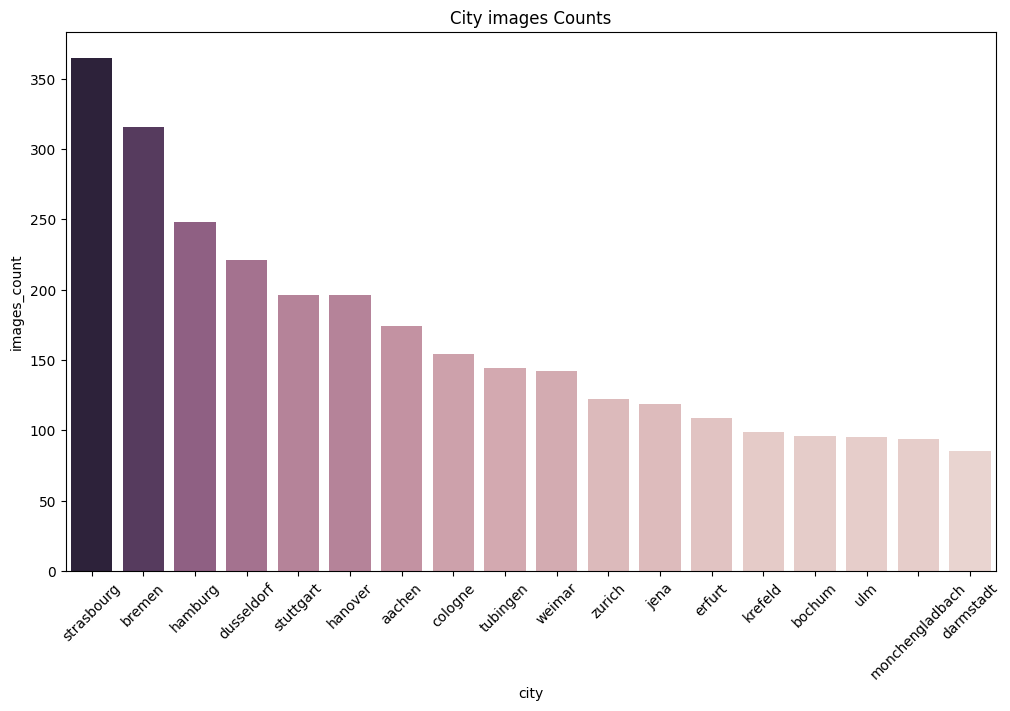

In [3]:
imag = []
for city in os.listdir(LEFTIMG_DIR):
    DIR = os.path.join(LEFTIMG_DIR, city)

    images_in_city = len([
        name for name in os.listdir(DIR)
        if os.path.isfile(os.path.join(DIR, name))
    ])
    imag.append({"city": city, "images_count": images_in_city})
im = pd.DataFrame(imag)
df = im.sort_values('images_count', ascending=False)
print(f'Images per city\n {df}')

plt.figure(figsize=(12, 7))
sns.barplot(data=df, x='city', y='images_count', hue='images_count',  legend=False)

plt.title('City images Counts')
plt.xticks(rotation=45)
plt.show()

In [ ]:
images_info = []
for city in os.listdir(LEFTIMG_DIR):
    city_path = os.path.join(LEFTIMG_DIR, city)
    for file in os.listdir(city_path):
        if file.endswith("_leftImg8bit.png"):
            label_path = os.path.join(city_path, file)
            image = cv2.imread(label_path)
            height, width = image.shape[:2]

            img = image.astype(np.float32) / 255.0
            mean = img.mean(axis=(0, 1))
            std = img.std(axis=(0, 1))
            mean_rgb = mean[::-1]
            std_rgb = std[::-1]
            images_info.append({
                "image": file,
                "hight": height,
                "width": width,
                "size": image.size,
                "type": image.dtype,
                "mean RGB": mean_rgb,
                "std RGB": std_rgb
            })
infodf = pd.DataFrame(images_info)
infodf

In [ ]:
infodf.describe()

,hight,width,size
count,2975.0,2975.0,2975.0
mean,1024.0,2048.0,6291456.0
std,0.0,0.0,0.0
min,1024.0,2048.0,6291456.0
25%,1024.0,2048.0,6291456.0
50%,1024.0,2048.0,6291456.0
75%,1024.0,2048.0,6291456.0
max,1024.0,2048.0,6291456.0


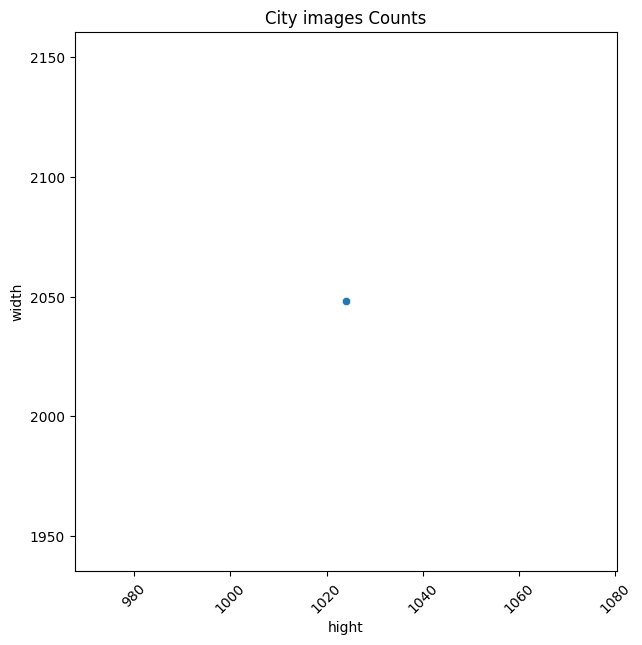

In [ ]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=infodf, x='hight', y='width')

plt.title('City images Counts')
plt.xticks(rotation=45)
plt.show()

In [ ]:
id_to_trainId = np.full(256, 255, dtype=np.uint8)

for l in labels:
    if l.trainId == -1:
        id_to_trainId[l.id] = 255
    else:
        id_to_trainId[l.id] = l.trainId

CAR_CLASS_ID = 13
results = []
pixel_counts = defaultdict(int)
total_pixels = 0
images_no_cars_per_city = pd.DataFrame()
for city in os.listdir(GT_DIR):
    city_path = os.path.join(GT_DIR, city)
    for file in os.listdir(city_path):
        if file.endswith("_labelIds.png"):
            label_path = os.path.join(city_path, file)
            label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)

            height, width = label.shape

            train_label = id_to_trainId[label]

            unique_classes = set(np.unique(train_label)) - {255}
            num_unique_classes = len(unique_classes)

            car_pixels = np.sum(train_label == CAR_CLASS_ID)


            results.append({
                "image": file,
                "height": height,
                "width": width,
                "number_of_pixels": label.size,
                "num_classes": num_unique_classes,
                "car_pixels": car_pixels,
                "car_percentage": ((car_pixels / label.size) * 100)
            })

infodf = pd.DataFrame(results)
infodf

,image,height,width,number_of_pixels,num_classes,car_pixels,car_percentage
0,aachen_000000_000019_gtFine_labelIds.png,1024,2048,2097152,12,42659,2.034140
1,aachen_000001_000019_gtFine_labelIds.png,1024,2048,2097152,12,32864,1.567078
2,aachen_000002_000019_gtFine_labelIds.png,1024,2048,2097152,13,109686,5.230236
3,aachen_000003_000019_gtFine_labelIds.png,1024,2048,2097152,11,175066,8.347797
4,aachen_000004_000019_gtFine_labelIds.png,1024,2048,2097152,14,57898,2.760792
...,...,...,...,...,...,...,...
2970,zurich_000117_000019_gtFine_labelIds.png,1024,2048,2097152,14,100579,4.795980
2971,zurich_000118_000019_gtFine_labelIds.png,1024,2048,2097152,15,35130,1.675129
2972,zurich_000119_000019_gtFine_labelIds.png,1024,2048,2097152,15,44490,2.121449
2973,zurich_000120_000019_gtFine_labelIds.png,1024,2048,2097152,10,181389,8.649302


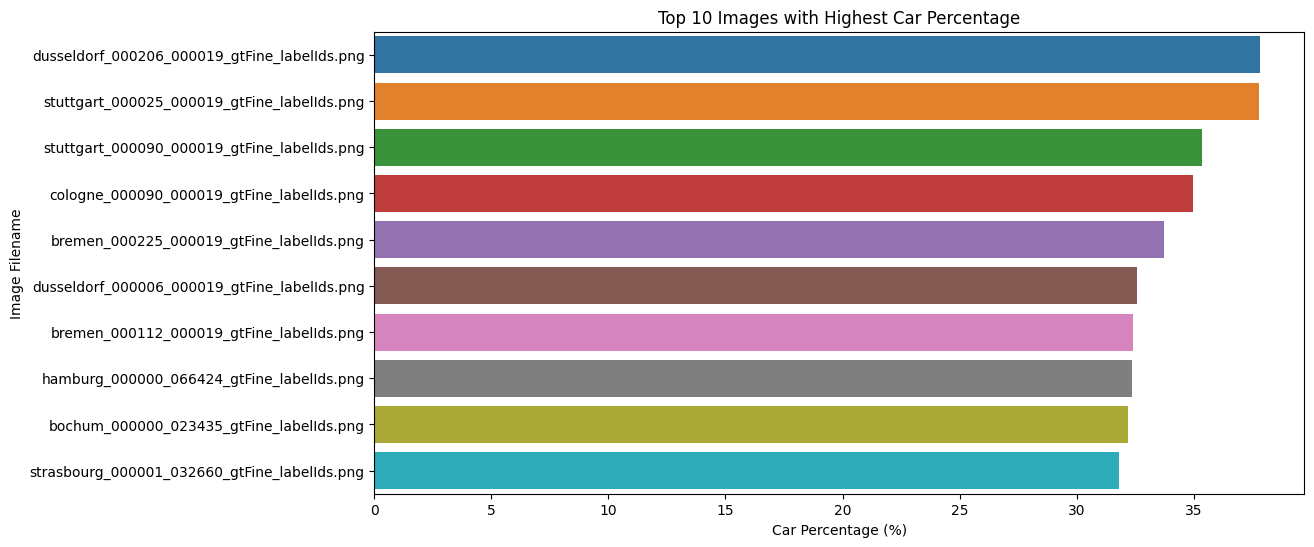

In [ ]:
top_10_cars = infodf.sort_values(by='car_percentage', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_cars, x='car_percentage', y='image', hue='image',  legend=False)
plt.title('Top 10 Images with Highest Car Percentage')
plt.xlabel('Car Percentage (%)')
plt.ylabel('Image Filename')
plt.show()

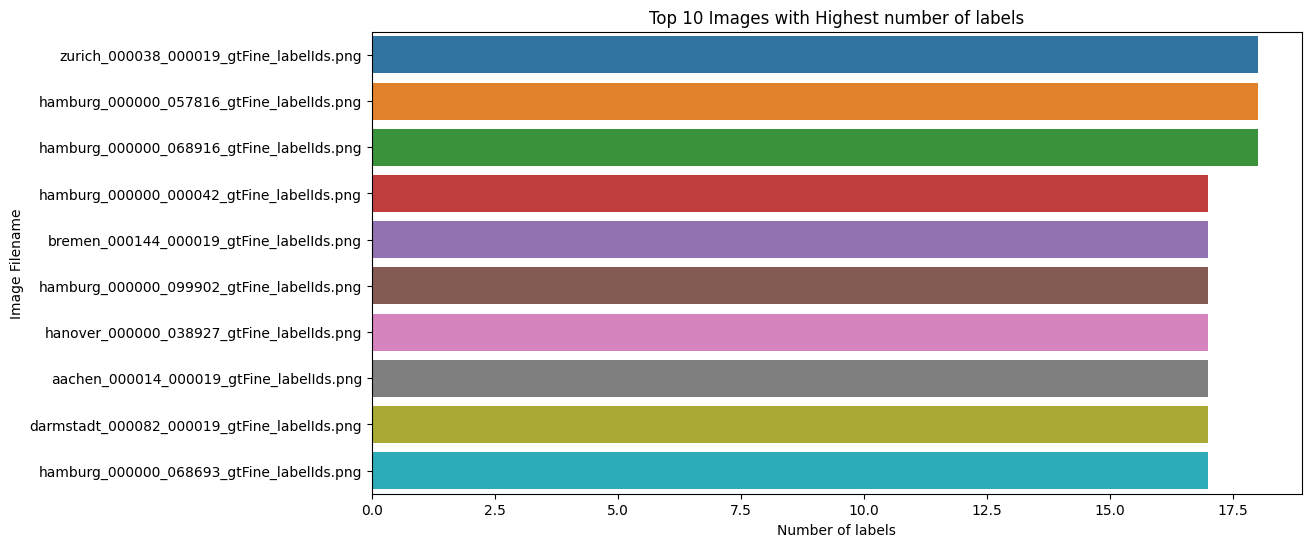

In [ ]:
top_10_labels = infodf.sort_values(by='num_classes', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_labels, x='num_classes', y='image', hue='image',  legend=False)
plt.title('Top 10 Images with Highest number of labels')
plt.xlabel('Number of labels')
plt.ylabel('Image Filename')
plt.show()

# Techniques for image processing and feature extraction.

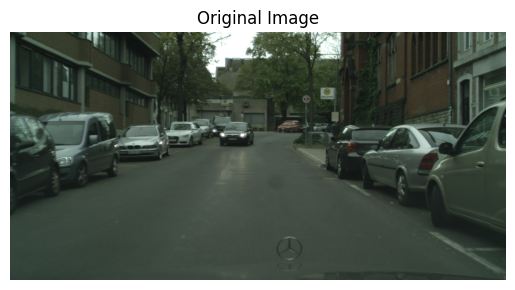

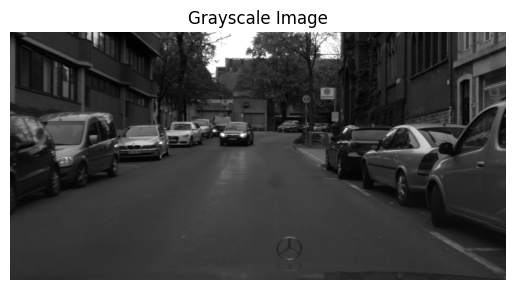

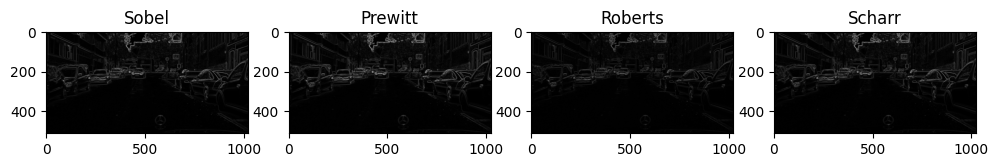

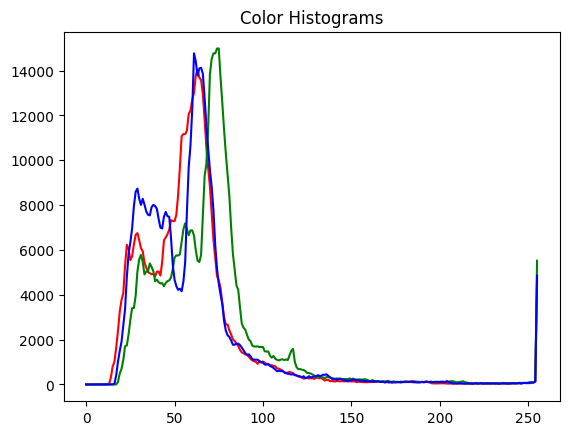

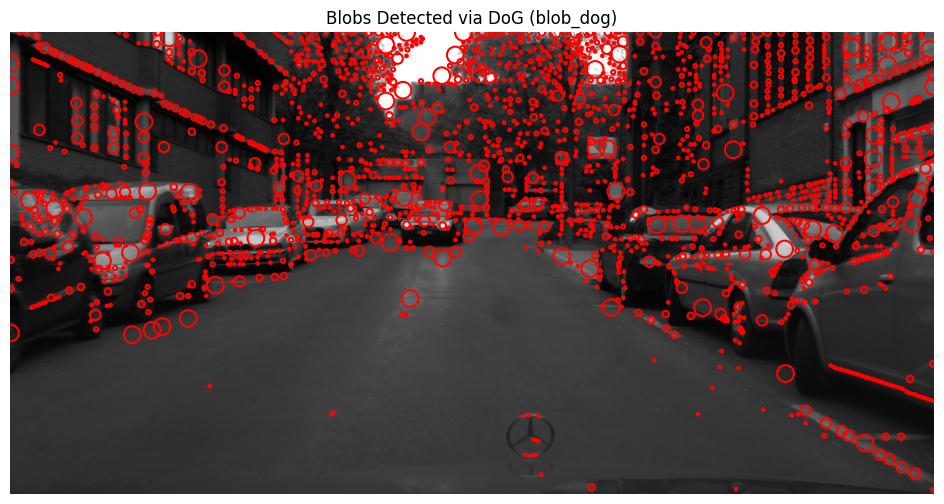

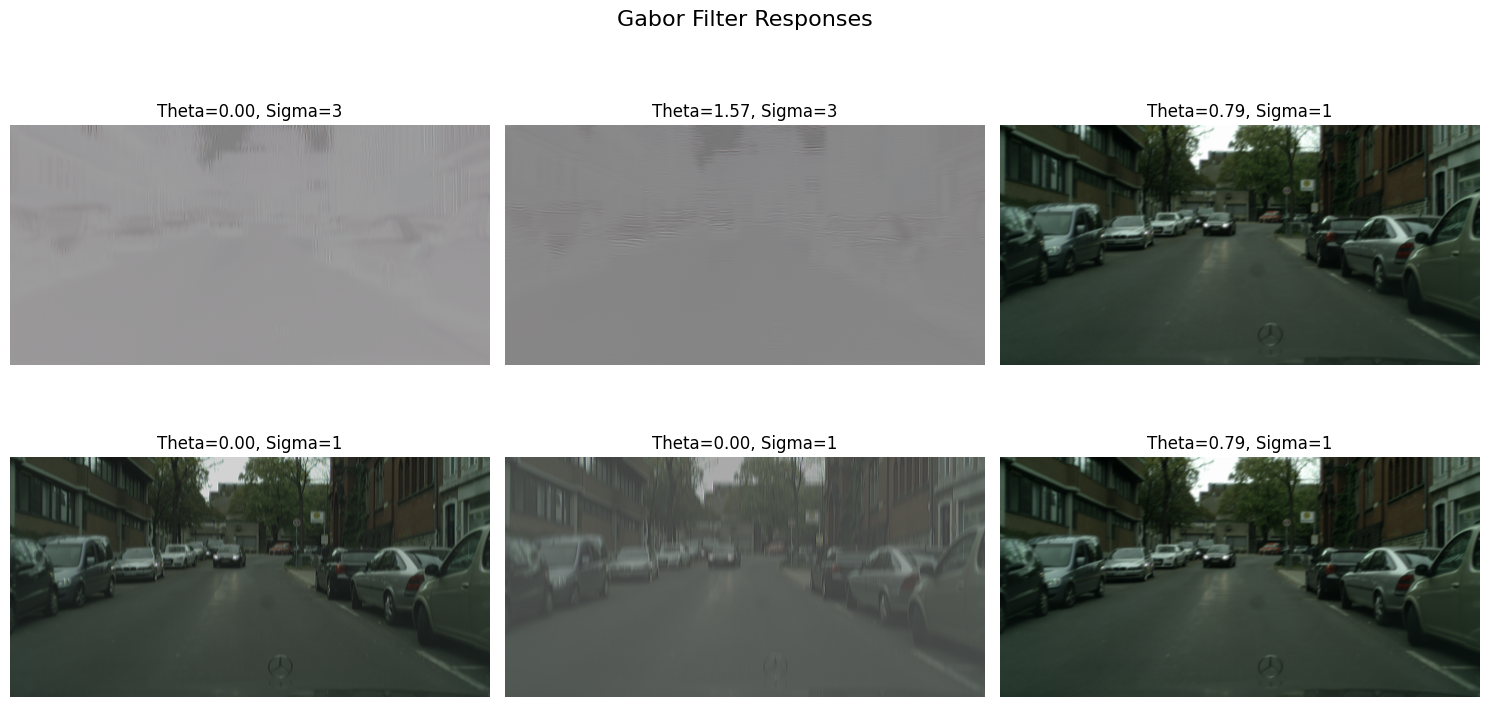

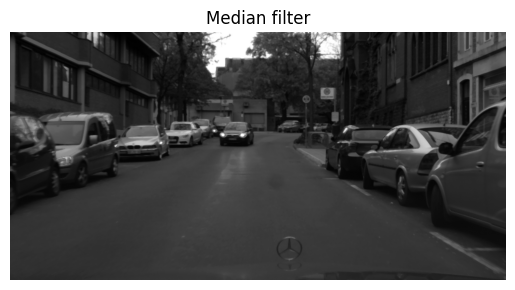

In [ ]:
image_path = 'datasets/cityscapes/leftImg8bit/train/aachen/aachen_000043_000019_leftImg8bit.png'
img_read = cv2.imread(image_path)
img_resized = cv2.resize(img_read, (1024, 512))
img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()

robimg = roberts(img_gray)
sobelimg = sobel(img_gray)
scharrimg = scharr(img_gray)
prewittimg = prewitt(img_gray)

plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(sobelimg, cmap='gray'); plt.title("Sobel")
plt.subplot(1,4,2); plt.imshow(prewittimg, cmap='gray'); plt.title("Prewitt")
plt.subplot(1,4,3); plt.imshow(robimg, cmap='gray'); plt.title("Roberts")
plt.subplot(1,4,4); plt.imshow(scharrimg, cmap='gray'); plt.title("Scharr")
plt.show()

colors = ('r','g','b')
plt.figure()
for i,col in enumerate(colors):
    hist = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(hist,color=col)
plt.title("Color Histograms")
plt.show()

blobs = blob_dog(
    img_gray,
    min_sigma=1,
    max_sigma=10,
    sigma_ratio=1.6,
    threshold=0.02,
    overlap=0.5
)
plt.figure(figsize=(12, 6))
plt.imshow(img_gray, cmap='gray')
for y, x, sigma in blobs:
    c = plt.Circle((x, y), sigma * np.sqrt(2), color='red', linewidth=1.5, fill=False)
    plt.gca().add_patch(c)
plt.title("Blobs Detected via DoG (blob_dog)")
plt.axis('off')
plt.show()

gabor_params = [
    (0, 3, np.pi / 2, 0.5),
    (np.pi / 2, 3, np.pi / 2, 0.5),
    (np.pi / 4, 1, np.pi / 4, 0.5),
    (0, 1, np.pi / 4, 0.5),
    (0, 1, np.pi / 2, 0.05),
    (np.pi / 4, 1, np.pi / 4, 0.5)
]
plt.figure(figsize=(15, 8))
for i, (theta, sigma, lamda, gamma) in enumerate(gabor_params, 1):
    kernel = cv2.getGaborKernel((15, 15), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)

    fimg = cv2.filter2D(img, cv2.CV_32F, kernel)

    fimg_norm = cv2.normalize(fimg, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    plt.subplot(2, 3, i)
    plt.imshow(fimg_norm, cmap='gray')
    plt.title(f"Theta={theta:.2f}, Sigma={sigma}")
    plt.axis('off')

plt.suptitle("Gabor Filter Responses", fontsize=16)
plt.tight_layout()
plt.show()

imgmed = nd.median_filter(img_gray, size=3)
plt.imshow(imgmed, cmap='gray')
plt.title("Median filter")
plt.axis('off')
plt.show()

# U-Net

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "modelUNET/unet.pt"


net = UNET(in_channels=3, classes=19).to(DEVICE)
checkpoint = torch.load(MODEL_PATH)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

image_path = "datasets/cityscapes/leftImg8bit/train/aachen/aachen_000043_000019_leftImg8bit.png"
mask_path  = "datasets/cityscapes/gtFine/train/aachen/aachen_000043_000019_gtFine_labelIds.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

image = cv2.resize(image, (512, 256))
true_mask = cv2.resize(true_mask, (512, 256), interpolation=cv2.INTER_NEAREST)

image_tensor = torch.tensor(image).permute(2, 0, 1).float() / 255.0
image_tensor = image_tensor.unsqueeze(0).to(DEVICE)

with torch.no_grad():
    output = net(image_tensor)
    pred_mask = torch.argmax(output, dim=1)

pred_mask = pred_mask.squeeze().cpu().numpy()

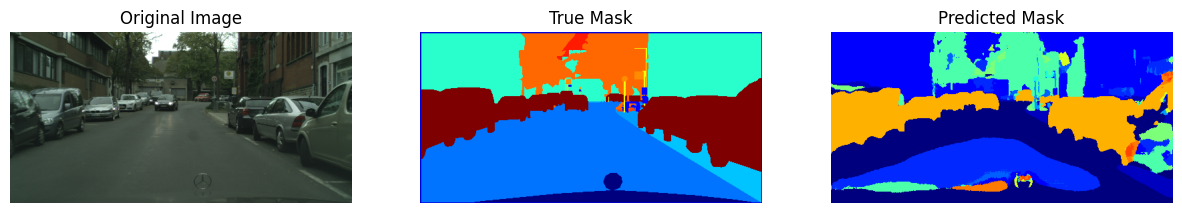

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("True Mask")
plt.imshow(true_mask, cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap="jet")
plt.axis("off")

plt.show()


In [ ]:
IMAGE_DIR = "datasets/cityscapes/leftImg8bit/val/munster"
MASK_DIR  = "datasets/cityscapes/gtFine/val/munster"
NUM_CLASSES = 19

def dice_coefficient(pred, target, num_classes):
    dice_per_class = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = (pred_cls * target_cls).sum()
        denominator = pred_cls.sum() + target_cls.sum()
        if denominator == 0:
            continue
        dice = 2 * intersection / denominator
        dice_per_class.append(dice)
    if len(dice_per_class) == 0:
        return torch.tensor(0.0)
    return torch.mean(torch.stack(dice_per_class))

def iou_torch(pred, target, num_classes):
    pred = pred.view(-1)
    target = target.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_cls = pred == cls
        target_cls = target == cls
        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()
        if union == 0:
            continue
        ious.append(intersection / union)
    if len(ious) == 0:
        return torch.tensor(0.0)
    return torch.mean(torch.stack(ious))

def compute_metrics(pred, target, num_classes):
    pred_mask_np = pred_mask.cpu().numpy()
    mask_np = mask_tensor.cpu().numpy()
    pred_flat = pred.view(-1).cpu().numpy()
    target_flat = target.view(-1).cpu().numpy()

    precision = precision_score(target_flat, pred_flat, average='macro', zero_division=0)
    recall = recall_score(target_flat, pred_flat, average='macro', zero_division=0)
    accuracy = accuracy_score(target_flat, pred_flat)

    dice = dice_coefficient(pred, target, num_classes).item()
    jaccard = iou_torch(pred, target, num_classes).item()

    return {
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
        "Dice": dice,
        "IoU": jaccard
    }
img_paths = []
mask_paths = []

for f in os.listdir(IMAGE_DIR):
    if f.endswith("_leftImg8bit.png"):
        img_paths.append(os.path.join(IMAGE_DIR, f))
        mask_name = f.replace("_leftImg8bit.png", "_gtFine_labelTrainIds.png")
        mask_paths.append(os.path.join(MASK_DIR, mask_name))

results = []

for img_path, mask_path in tqdm(zip(img_paths, mask_paths), total=len(img_paths)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (110, 220))

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (110, 220), interpolation=cv2.INTER_NEAREST)

    img_tensor = torch.tensor(img).permute(2,0,1).unsqueeze(0).float() / 255.0
    img_tensor = img_tensor.to(DEVICE)
    mask_tensor = torch.tensor(mask).long().to(DEVICE)

    with torch.no_grad():
        output = net(img_tensor)
        pred_mask = torch.argmax(output, dim=1).squeeze(0)

    metrics = compute_metrics(pred_mask, mask_tensor, NUM_CLASSES)
    results.append(metrics)

df_metrics = pd.DataFrame(results)
print(df_metrics)

mean_metrics = df_metrics.mean()
print("\nMean metrics across dataset:")
print(mean_metrics)

100%|██████████| 174/174 [00:22<00:00,  7.77it/s]

     Precision    Recall  Accuracy      Dice       IoU
0     0.254793  0.242195  0.550868  0.225759  0.161057
1     0.284793  0.284844  0.802521  0.292755  0.246305
2     0.318810  0.253173  0.721281  0.258136  0.203865
3     0.236397  0.207800  0.558471  0.208921  0.161194
4     0.256837  0.196341  0.456116  0.207114  0.150454
..         ...       ...       ...       ...       ...
169   0.188431  0.183002  0.432727  0.174881  0.124255
170   0.176951  0.121552  0.573347  0.127777  0.097785
171   0.297498  0.276884  0.564752  0.264200  0.199739
172   0.255779  0.182908  0.480413  0.184893  0.136423
173   0.210772  0.226713  0.508636  0.194868  0.150850

[174 rows x 5 columns]

Mean metrics across dataset:
Precision    0.250889
Recall       0.216923
Accuracy     0.589668
Dice         0.216530
IoU          0.164555
dtype: float64


# SVM and CatBoost with my Feature selection

In [ ]:
image_dir = "datasets/cityscapes/leftImg8bit/train/aachen"
mask_dir = "datasets/cityscapes/gtFine/train/aachen"

all_images = [f for f in os.listdir(image_dir) if f.endswith("_leftImg8bit.png")]
random.seed(42)
random_images = random.sample(all_images, 10)
print("Selected images:", random_images)


gabor_params = [
    (0, 3, np.pi / 2, 0.5),
    (np.pi / 2, 3, np.pi / 2, 0.5),
    (np.pi / 4, 1, np.pi / 4, 0.5),
    (0, 1, np.pi / 4, 0.5),
    (0, 1, np.pi / 2, 0.05),
    (np.pi / 4, 1, np.pi / 4, 0.5)
]


image_rows = []

for image_name in random_images:
    print("Processing image:", image_name)

    img_path = os.path.join(image_dir, image_name)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (1024, 512))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    df = pd.DataFrame()
    df['Pixel_Value'] = img_gray.reshape(-1)
    df['Image_Name'] = image_name

    for i, (theta, sigma, lamda, gamma) in enumerate(gabor_params, 1):
        kernel = cv2.getGaborKernel((15, 15),
                                    sigma,
                                    theta,
                                    lamda,
                                    gamma,
                                    0,
                                    ktype=cv2.CV_32F)
        fimg = cv2.filter2D(img_gray, cv2.CV_32F, kernel)
        df[f"Gabor{i}"] = fimg.reshape(-1)

    df['Canny Edge'] = cv2.Canny(img_gray, 100, 200).reshape(-1)

    df['Roberts'] = roberts(img_gray).reshape(-1)
    df['Sobel'] = sobel(img_gray).reshape(-1)
    df['Scharr'] = scharr(img_gray).reshape(-1)
    df['Prewitt'] = prewitt(img_gray).reshape(-1)

    df['Gaussian s3'] = nd.gaussian_filter(img_gray, sigma=3).reshape(-1)
    df['Gaussian s7'] = nd.gaussian_filter(img_gray, sigma=7).reshape(-1)

    df['Median s3'] = nd.median_filter(img_gray, size=3).reshape(-1)

    df['Variance s3'] = nd.generic_filter(img_gray, np.var, size=3).reshape(-1)

    blobs = blob_dog(
            img_gray,
            min_sigma=23,
            max_sigma=30,
            sigma_ratio=1.6,
            threshold=0.03,
            overlap=0.1
        )

    dog_feature = np.zeros_like(img_gray, dtype=np.float32)
    for y, x, sigma in blobs:
        y, x = int(y), int(x)
        dog_feature[y, x] = sigma

    df['DoG Blob'] = dog_feature.reshape(-1)

    image_rows.append(df)

image_dataset = pd.concat(image_rows, ignore_index=True)
print("Image dataset shape:", image_dataset.shape)

mask_rows = []
for image_name in random_images:
    mask_name = image_name.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
    mask_path = os.path.join(mask_dir, mask_name)
    mask_img = cv2.imread(mask_path, 0)
    mask_img = cv2.resize(mask_img, (1024, 512), interpolation=cv2.INTER_NEAREST)

    df_mask = pd.DataFrame({'label': mask_img.reshape(-1)})
    mask_rows.append(df_mask)

mask_dataset = pd.concat(mask_rows, ignore_index=True)
print("Mask dataset shape:", mask_dataset.shape)


dataset = pd.concat([image_dataset, mask_dataset], axis=1)
print("Final dataset shape:", dataset.shape)


Selected images: ['aachen_000163_000019_leftImg8bit.png', 'aachen_000028_000019_leftImg8bit.png', 'aachen_000006_000019_leftImg8bit.png', 'aachen_000070_000019_leftImg8bit.png', 'aachen_000062_000019_leftImg8bit.png', 'aachen_000057_000019_leftImg8bit.png', 'aachen_000035_000019_leftImg8bit.png', 'aachen_000026_000019_leftImg8bit.png', 'aachen_000173_000019_leftImg8bit.png', 'aachen_000139_000019_leftImg8bit.png']
Processing image: aachen_000163_000019_leftImg8bit.png
Processing image: aachen_000028_000019_leftImg8bit.png
Processing image: aachen_000006_000019_leftImg8bit.png
Processing image: aachen_000070_000019_leftImg8bit.png
Processing image: aachen_000062_000019_leftImg8bit.png
Processing image: aachen_000057_000019_leftImg8bit.png
Processing image: aachen_000035_000019_leftImg8bit.png
Processing image: aachen_000026_000019_leftImg8bit.png
Processing image: aachen_000173_000019_leftImg8bit.png
Processing image: aachen_000139_000019_leftImg8bit.png
Image dataset shape: (5242880, 1

In [ ]:
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = dataset.drop(columns=['label', 'Image_Name']).values
y = dataset['label'].values

X, y = shuffle(X, y, random_state=42)

X = X[:100000]
y = y[:100000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",50
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

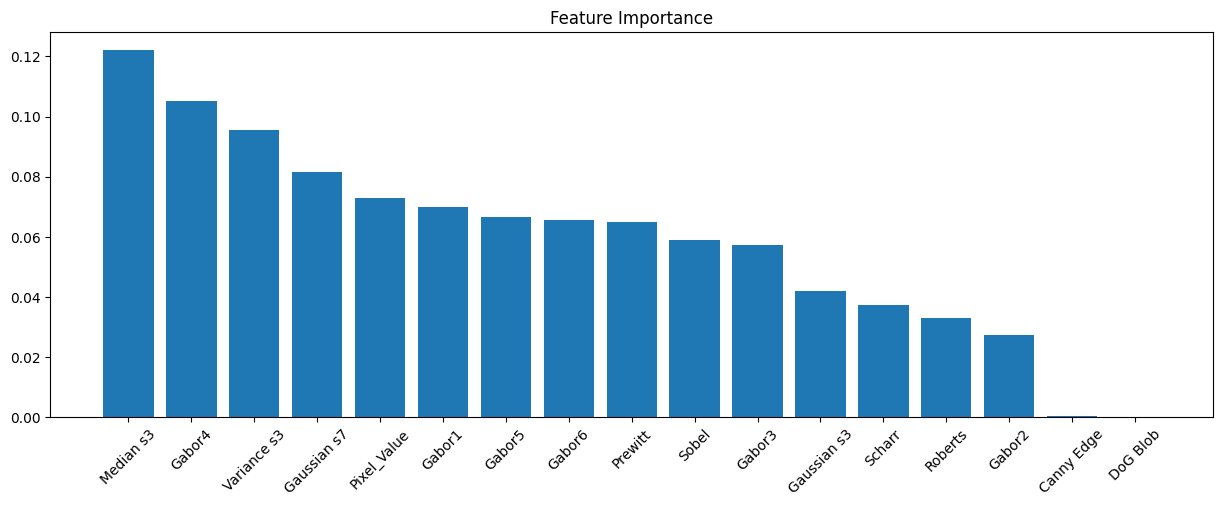

In [ ]:
feature_names = dataset.drop(columns=['label', 'Image_Name']).columns
feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf.feature_importances_
})

feature_importance = feature_importance.sort_values(by="Importance",
                                                    ascending=False)

plt.figure(figsize=(15,5))
plt.bar(feature_importance["Feature"],
        feature_importance["Importance"])
plt.xticks(rotation=45)
plt.title("Feature Importance")
plt.show()

In [ ]:
city_name = "aachen"
image_dir = f"datasets/cityscapes/leftImg8bit/train/{city_name}"
mask_dir = f"datasets/cityscapes/gtFine/train/{city_name}"

image_files = [f for f in os.listdir(image_dir) if f.endswith("_leftImg8bit.png")]

image_rows = []

for file in image_files:
    print("Processing:", file)


    img_path = os.path.join(image_dir, file)
    mask_path = os.path.join(mask_dir, file.replace("_leftImg8bit.png", "_gtFine_labelIds.png"))

    img = cv2.imread(img_path)
    img = cv2.resize(img, (1024, 512))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    mask_img = cv2.imread(mask_path, 0)
    mask_img = cv2.resize(mask_img, (1024, 512), interpolation=cv2.INTER_NEAREST)

    df = pd.DataFrame()
    df['Pixel_Value'] = img_gray.reshape(-1)
    df['label'] = mask_img.reshape(-1)

    kernel = cv2.getGaborKernel((15, 15), sigma=1, theta=0, lambd=np.pi/4, gamma=0.5, psi=0, ktype=cv2.CV_32F)
    fimg = cv2.filter2D(img_gray, cv2.CV_32F, kernel)
    df['Gabor'] = fimg.reshape(-1)

    df['Median s3'] = nd.median_filter(img_gray, size=3).reshape(-1)

    image_rows.append(df)

city_dataset = pd.concat(image_rows, ignore_index=True)
print("City dataset shape:", city_dataset.shape)

X = city_dataset.drop(columns=['label']).values
y = city_dataset['label'].values

print("X shape:", X.shape)
print("y shape:", y.shape)

Processing: aachen_000000_000019_leftImg8bit.png
Processing: aachen_000001_000019_leftImg8bit.png
Processing: aachen_000002_000019_leftImg8bit.png
Processing: aachen_000003_000019_leftImg8bit.png
Processing: aachen_000004_000019_leftImg8bit.png
Processing: aachen_000005_000019_leftImg8bit.png
Processing: aachen_000006_000019_leftImg8bit.png
Processing: aachen_000007_000019_leftImg8bit.png
Processing: aachen_000008_000019_leftImg8bit.png
Processing: aachen_000009_000019_leftImg8bit.png
Processing: aachen_000010_000019_leftImg8bit.png
Processing: aachen_000011_000019_leftImg8bit.png
Processing: aachen_000012_000019_leftImg8bit.png
Processing: aachen_000013_000019_leftImg8bit.png
Processing: aachen_000014_000019_leftImg8bit.png
Processing: aachen_000015_000019_leftImg8bit.png
Processing: aachen_000016_000019_leftImg8bit.png
Processing: aachen_000017_000019_leftImg8bit.png
Processing: aachen_000018_000019_leftImg8bit.png
Processing: aachen_000019_000019_leftImg8bit.png
Processing: aachen_0

In [ ]:
X_all = X.astype(np.float32)
y_all = y.copy()

X_all = X[:1000000]
y_all = y[:1000000]

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [ ]:
svm_model = LinearSVC(class_weight='balanced', max_iter=5000)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)

print("SVM Results:")
print(classification_report(y_test, y_pred_svm))

SVM Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00      4461
           3       0.01      0.01      0.01      2653
           4       0.00      0.00      0.00      1707
           5       0.00      0.21      0.00        33
           6       0.00      0.00      0.00      1450
           7       0.66      0.86      0.75     77954
           8       0.02      0.01      0.02      2702
          11       0.55      0.00      0.01     52087
          12       0.01      0.23      0.02       388
          13       0.03      0.02      0.02      1336
          17       0.00      0.00      0.00      2230
          19       0.00      0.62      0.00         8
          20       0.09      0.02      0.03      1945
          21       0.20      0.35      0.26     21837
          22       0.00      0.00      0.00     13024
          23       0.54      0.99      0.70     12101
          24  

d:\mlproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\mlproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\mlproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
cb = CatBoostClassifier(
    iterations=100,
    depth=8,
    learning_rate=0.1,
    loss_function='MultiClass',
    verbose=50,
    thread_count=-1,
    random_seed=42
)

cb.fit(X_train, y_train)
y_pred_cat = cb.predict(X_test)
print("CatBoost Results:")
print(classification_report(y_test, y_pred_cat))

0:	learn: 2.2532114	total: 1.45s	remaining: 2m 23s
50:	learn: 1.1457852	total: 54.7s	remaining: 52.5s
99:	learn: 1.1051829	total: 1m 45s	remaining: 0us
CatBoost Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00      4461
           3       0.00      0.00      0.00      2653
           4       0.00      0.00      0.00      1707
           5       0.00      0.00      0.00        33
           6       0.00      0.00      0.00      1450
           7       0.70      0.91      0.79     77954
           8       0.00      0.00      0.00      2702
          11       0.55      0.69      0.61     52087
          12       0.75      0.01      0.02       388
          13       0.50      0.02      0.04      1336
          17       0.67      0.02      0.04      2230
          19       0.00      0.00      0.00         8
          20       0.70      0.00      0.01      1945
          21       

d:\mlproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\mlproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\mlproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


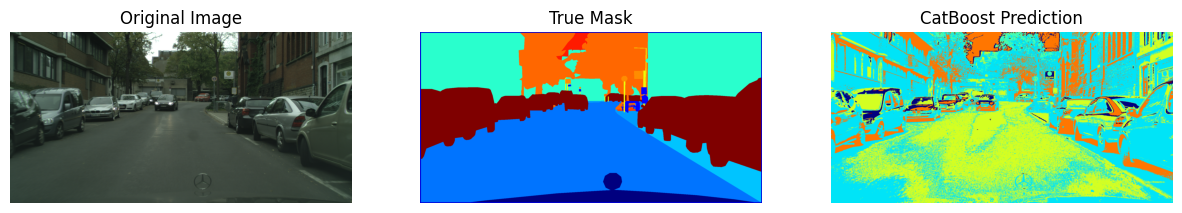

In [ ]:
image_path = "datasets/cityscapes/leftImg8bit/train/aachen/aachen_000043_000019_leftImg8bit.png"
mask_path  = "datasets/cityscapes/gtFine/train/aachen/aachen_000043_000019_gtFine_labelIds.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

H, W = true_mask.shape
X_image = image.reshape(-1, 3)
y_pred = cb.predict(X_image)
y_pred = y_pred.reshape(H, W)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("True Mask")
plt.imshow(true_mask, cmap="jet")
plt.axis("off")

plt.subplot(1,3,3)
plt.title("CatBoost Prediction")
plt.imshow(y_pred, cmap="jet")
plt.axis("off")

plt.show()


In [ ]:
for img_path, mask_path in tqdm(zip(img_paths, mask_paths), total=len(img_paths)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


    H, W = true_mask.shape
    X_image = img.reshape(-1, 3)
    y_pred = cb.predict(X_image)
    y_pred = y_pred.reshape(H, W)

    metrics = compute_metrics(pred_mask, mask_tensor, NUM_CLASSES)
    results.append(metrics)

df_metrics = pd.DataFrame(results)
print(f'{df_metrics}')


100%|██████████| 174/174 [15:07<00:00,  5.21s/it]

     Precision    Recall  Accuracy      Dice       IoU
0     0.254793  0.242195  0.550868  0.225759  0.161057
1     0.284793  0.284844  0.802521  0.292755  0.246305
2     0.318810  0.253173  0.721281  0.258136  0.203865
3     0.236397  0.207800  0.558471  0.208921  0.161194
4     0.256837  0.196341  0.456116  0.207114  0.150454
..         ...       ...       ...       ...       ...
343   0.210772  0.226713  0.508636  0.194868  0.150850
344   0.210772  0.226713  0.508636  0.194868  0.150850
345   0.210772  0.226713  0.508636  0.194868  0.150850
346   0.210772  0.226713  0.508636  0.194868  0.150850
347   0.210772  0.226713  0.508636  0.194868  0.150850

[348 rows x 5 columns]

Mean metrics across dataset:


In [ ]:
mean_metrics = df_metrics.mean()
print(f"\nMean metrics across dataset:\n {mean_metrics}")


Mean metrics across dataset:
 Precision    0.230831
Recall       0.221818
Accuracy     0.549152
Dice         0.205699
IoU          0.157702
dtype: float64


# SVM and CatBoost with VGG

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg = models.vgg16(pretrained=True)
vgg.eval()
vgg.to(device)

class VGG16_FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.features = original_model.features
        self.avgpool = original_model.avgpool

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

feature_extractor = VGG16_FeatureExtractor(vgg).to(device)
feature_extractor.eval()

VGG16_FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pa

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

In [ ]:
from tqdm import tqdm

def extract_features(img_paths, mask_paths, patch_size=32, max_patches=50):
    X_all, y_all = [], []

    for img_path, mask_path in tqdm(zip(img_paths, mask_paths), total=len(img_paths)):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, 0)
        h, w = mask.shape

        for _ in range(max_patches):
            x = np.random.randint(0, w - patch_size)
            y = np.random.randint(0, h - patch_size)

            patch = img[y:y+patch_size, x:x+patch_size]
            mask_patch = mask[y:y+patch_size, x:x+patch_size]

            unique, counts = np.unique(mask_patch, return_counts=True)
            majority = unique[np.argmax(counts)]
            if majority == 255:
                continue

            patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
            patch_tensor = transform(patch_rgb).unsqueeze(0).to(device)
            with torch.no_grad():
                features = feature_extractor(patch_tensor)

            X_all.append(features.cpu().numpy().flatten())
            y_all.append(majority)

    return np.array(X_all), np.array(y_all)


In [ ]:
CITY = "aachen"

LEFTIMG_DIR = os.path.join(DATASET_DIR, "leftImg8bit/train", CITY)
GT_DIR = os.path.join(DATASET_DIR, "gtFine/train", CITY)
img_paths = []
mask_paths = []

for f in os.listdir(LEFTIMG_DIR):
    if f.endswith("_leftImg8bit.png"):
        img_paths.append(os.path.join(LEFTIMG_DIR, f))
        mask_name = f.replace("_leftImg8bit.png", "_gtFine_labelTrainIds.png")
        mask_paths.append(os.path.join(GT_DIR, mask_name))

print("Number of images:", len(img_paths))

Number of images: 174


In [ ]:
X, y = extract_features(img_paths, mask_paths, patch_size=32, max_patches=50)
print("Feature shape:", X.shape)
print("Label shape:", y.shape)

100%|██████████| 174/174 [03:10<00:00,  1.10s/it]


Feature shape: (8135, 25088)
Label shape: (8135,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n_components = 512

pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train)

X_test_pca = pca.transform(X_test)

print("Original feature size:", X_train.shape[1])
print("Reduced feature size:", X_train_pca.shape[1])

Original feature size: 25088
Reduced feature size: 512


In [ ]:
svm_clf = SVC(kernel='linear', class_weight='balanced')
svm_clf.fit(X_train_pca, y_train)

y_pred = svm_clf.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       592
           1       0.48      0.48      0.48        99
           2       0.73      0.73      0.73       428
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         7
           5       0.25      0.10      0.14        10
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         8
           8       0.82      0.89      0.85       263
           9       0.30      0.18      0.22        17
          10       0.93      0.93      0.93        45
          11       0.32      0.38      0.35        21
          12       0.00      0.00      0.00         1
          13       0.56      0.50      0.53       117
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         4
          17       0.00      0.00      0.00         2
          18       0.00    

d:\mlproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\mlproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\mlproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
cat_clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    verbose=50
)
cat_clf.fit(X_train_pca, y_train)
y_pred = cat_clf.predict(X_test_pca)
print(classification_report(y_test, y_pred))

0:	learn: 2.3325367	total: 1.5s	remaining: 12m 28s
50:	learn: 0.8200476	total: 1m 19s	remaining: 11m 40s
100:	learn: 0.6255583	total: 2m 31s	remaining: 9m 59s
150:	learn: 0.4869969	total: 3m 41s	remaining: 8m 32s
200:	learn: 0.3876655	total: 4m 52s	remaining: 7m 14s
250:	learn: 0.3115210	total: 6m 2s	remaining: 5m 59s
300:	learn: 0.2520274	total: 7m 15s	remaining: 4m 47s
350:	learn: 0.2090594	total: 8m 32s	remaining: 3m 37s
400:	learn: 0.1766927	total: 9m 48s	remaining: 2m 25s
450:	learn: 0.1489940	total: 11m 3s	remaining: 1m 12s
499:	learn: 0.1287753	total: 12m 18s	remaining: 0us
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       592
           1       0.59      0.32      0.42        99
           2       0.66      0.79      0.72       428
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00        10
           6       0.00      0.00

d:\mlproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\mlproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\mlproject\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


# Semantic Segmentation Using DeeplabV3

In [ ]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MODEL_PATH = "deep/deeplabv3_tenep.pt"

# print(os.path.getsize(MODEL_PATH))

# model = models.segmentation.deeplabv3_resnet50(weights=None)

# model.classifier[4] = nn.Conv2d(256, 19, kernel_size=1)

# model = model.to(DEVICE)

# checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

# model.load_state_dict(checkpoint)


# model.eval()


# image_path = "datasets/cityscapes/leftImg8bit/train/aachen/aachen_000043_000019_leftImg8bit.png"
# mask_path  = "datasets/cityscapes/gtFine/train/aachen/aachen_000043_000019_gtFine_labelIds.png"

# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# image = cv2.resize(image, (512, 256))
# true_mask = cv2.resize(true_mask, (512, 256), interpolation=cv2.INTER_NEAREST)

# image_tensor = torch.tensor(image).permute(2, 0, 1).float() / 255.0
# image_tensor = image_tensor.unsqueeze(0).to(DEVICE)


# with torch.no_grad():
#     output = model(image_tensor)['out']
#     pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()


# print("Prediction shape:", pred_mask.shape)